## Importing the Relevant Libraries

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score,recall_score,accuracy_score,confusion_matrix,f1_score
from sklearn.metrics import precision_recall_curve,auc,roc_auc_score,roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgm
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

### Data Inspection

In [146]:
train = pd.read_csv("train_s3TEQDk.csv")
test = pd.read_csv("test_mSzZ8RL.csv")

In [4]:
train.shape, test.shape

((245725, 11), (105312, 10))

#### >Here we can see that, We have 245725 records,11 features in the train dataset and 105312 records,10 features in the test data set.

In [5]:
#ratio of null values
train.isnull().sum()/train.shape[0] *100

ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.934073
Avg_Account_Balance     0.000000
Is_Active               0.000000
Is_Lead                 0.000000
dtype: float64

There are around 12% data are missing in credit _product of training data set

In [6]:
#ratio of null values
test.isnull().sum()/test.shape[0] *100

ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.890383
Avg_Account_Balance     0.000000
Is_Active               0.000000
dtype: float64

In the test data set as well, there are around 12% datas are missing.

In [9]:
train.duplicated().sum()

0

There is not duplicate records in the training dataset

In [10]:
test.duplicated().sum()

0

There is not duplicate records in the test dataset as well.

In [7]:
#categorical features
categorical = train.select_dtypes(include =[np.object])
print("Categorical Features in Train Set:",categorical.shape[1])

#numerical features
numerical= train.select_dtypes(include =[np.float64,np.int64])
print("Numerical Features in Train Set:",numerical.shape[1])

Categorical Features in Train Set: 7
Numerical Features in Train Set: 4


In [21]:
print("All numerical data columns")
train._get_numeric_data().columns

All numerical data columns


Index(['Age', 'Vintage', 'Avg_Account_Balance', 'Is_Lead'], dtype='object')

In [22]:
print("All categorical data columns")
set(train.columns) - set(train._get_numeric_data().columns)

All categorical data columns


{'Channel_Code',
 'Credit_Product',
 'Gender',
 'ID',
 'Is_Active',
 'Occupation',
 'Region_Code'}

In [8]:
#categorical features
categorical = test.select_dtypes(include =[np.object])
print("Categorical Features in Test Set:",categorical.shape[1])

#numerical features
numerical= test.select_dtypes(include =[np.float64,np.int64])
print("Numerical Features in Test Set:",numerical.shape[1])

Categorical Features in Test Set: 7
Numerical Features in Test Set: 3


In [17]:
print("All numerical data columns")
test._get_numeric_data().columns

All numerical data columns


Index(['Age', 'Vintage', 'Avg_Account_Balance'], dtype='object')

In [18]:
print("All categorical data columns")
set(test.columns) - set(test._get_numeric_data().columns)

All categorical data columns


{'Channel_Code',
 'Credit_Product',
 'Gender',
 'ID',
 'Is_Active',
 'Occupation',
 'Region_Code'}

### Data Cleaning

There are around 12% datas from the feature credit_product is missing. This can reduce the precision of the model or we
can get the wrong predictions. So we have have to handle this. 

In [26]:
train['Credit_Product'].isnull().sum(),test['Credit_Product'].isnull().sum()

(29325, 12522)

In [27]:
print(train['Credit_Product'].value_counts())
print('******************************************')
print(test['Credit_Product'].value_counts())

No     144357
Yes     72043
Name: Credit_Product, dtype: int64
******************************************
No     61608
Yes    31182
Name: Credit_Product, dtype: int64


#### Since the Credit_Product is a categorical column, we can impute the missing values by "Mode"(frequency) from the column

In [147]:
#Imputing with Mode
train['Credit_Product']= train['Credit_Product'].fillna(train['Credit_Product'].mode()[0])
test['Credit_Product']= test['Credit_Product'].fillna(test['Credit_Product'].mode()[0])

In [148]:
train['Credit_Product'].isnull().sum(),test['Credit_Product'].isnull().sum()

(0, 0)

#### We have succesfully imputed the missing values.

# Exploratory Data Analysis

In [30]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [31]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,No,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [37]:
train.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


### Here are some Initial observation

* Max and min age of the customer is 85 and 23 respectively. average age of 75% of the customer is 54.
* max and min vintage of the customer is 135 and 7 months respectively. Average vintage of 75% of the customer is 73 months.
* max and min avg account balance is 1.035201e+07 and 2.079000e+04 Rs. 
* Here is_lead denotes that whether the customer is interested for the credit card or not. This is a categorical value. We have to change the data type here.

In [149]:
train['Is_Lead'] = train['Is_Lead'].apply(str)

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       245725 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  object
dtypes: int64(3), object(8)
memory usage: 20.6+ MB


## Univariate Analysis

### Gender

In [33]:
train.Gender.value_counts()

Male      134197
Female    111528
Name: Gender, dtype: int64

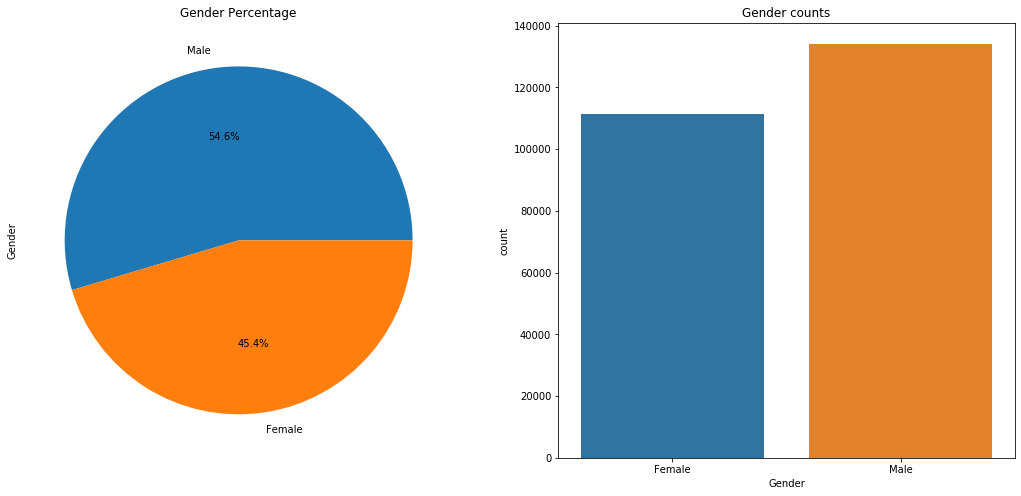

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,8))
train['Gender'].value_counts().plot.pie(explode=None,ax=ax1,autopct='%1.1f%%')
ax1.set_title('Gender Percentage')
sns.countplot(x='Gender', data=train, ax=ax2)
ax2.set_title('Gender counts')
plt.show()

* 54.6%(134197) customers are male and 45.4%(111528) customers are female.

### Age

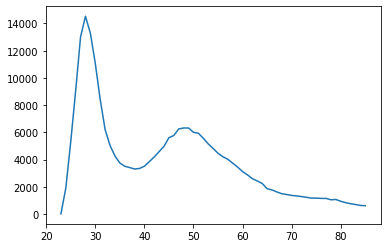

In [46]:
train['Age'].value_counts().sort_index().plot.line()

* most of the customers comes under the age of 25 to 35.

### Region_Code

In [51]:
train.Region_Code.value_counts()

RG268    35934
RG283    29416
RG254    26840
RG284    19320
RG277    12826
RG280    12775
RG269     7863
RG270     7720
RG261     7633
RG257     6101
RG251     5950
RG282     5829
RG274     5286
RG272     5252
RG281     5093
RG273     4497
RG252     4286
RG279     3976
RG263     3687
RG275     3245
RG260     3110
RG256     2847
RG264     2793
RG276     2764
RG259     2586
RG250     2496
RG255     2018
RG258     1951
RG253     1858
RG278     1822
RG262     1788
RG266     1578
RG265     1546
RG271     1542
RG267     1497
Name: Region_Code, dtype: int64

In [54]:
top_10_Regional_code = train['Region_Code'].value_counts().head(10)

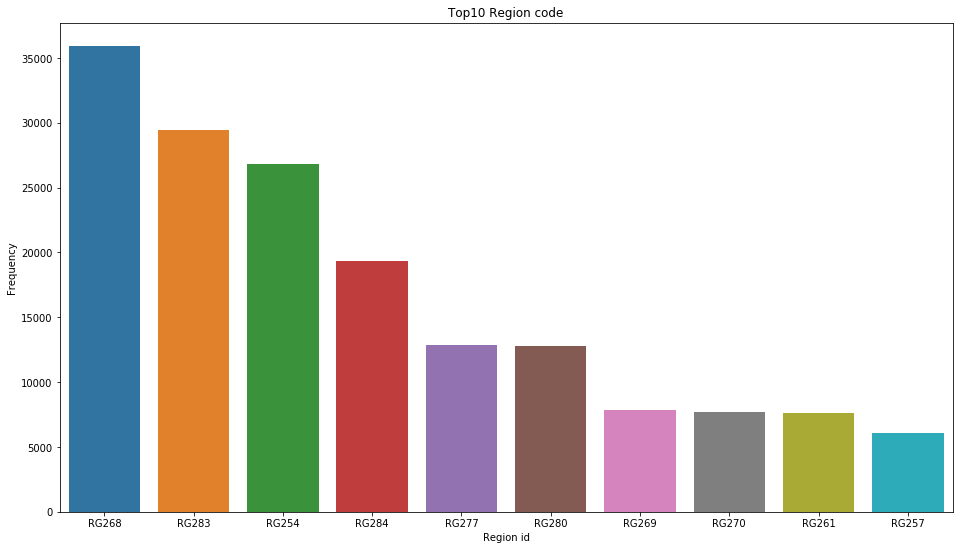

In [57]:
plt.figure(figsize=(16,9))
sns.barplot(x = top_10_Regional_code.index,y=top_10_Regional_code.values)
plt.xlabel('Region id')
plt.ylabel('Frequency')
plt.title('Top10 Region code')
plt.show()

### Occupation

In [58]:
train.Occupation.value_counts()

Self_Employed    100886
Salaried          71999
Other             70173
Entrepreneur       2667
Name: Occupation, dtype: int64

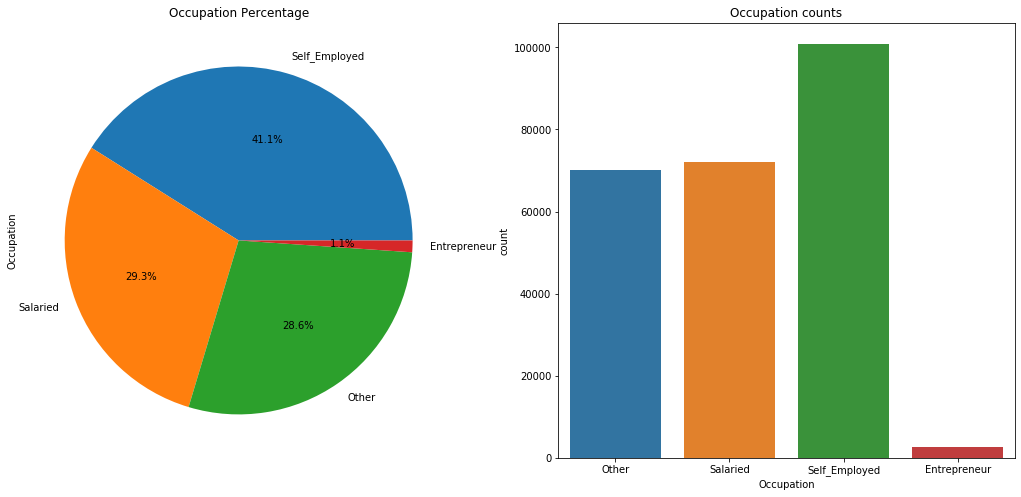

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,8))
train['Occupation'].value_counts().plot.pie(explode=None,ax=ax1,autopct='%1.1f%%')
ax1.set_title('Occupation Percentage')
sns.countplot(x='Occupation', data=train, ax=ax2)
ax2.set_title('Occupation counts')
plt.show()

* Most no of customers are self employed followed by salaried.
* very few are entrepreneur.

### Channel Code

In [60]:
train.Channel_Code.value_counts()

X1    103718
X3     68712
X2     67726
X4      5569
Name: Channel_Code, dtype: int64

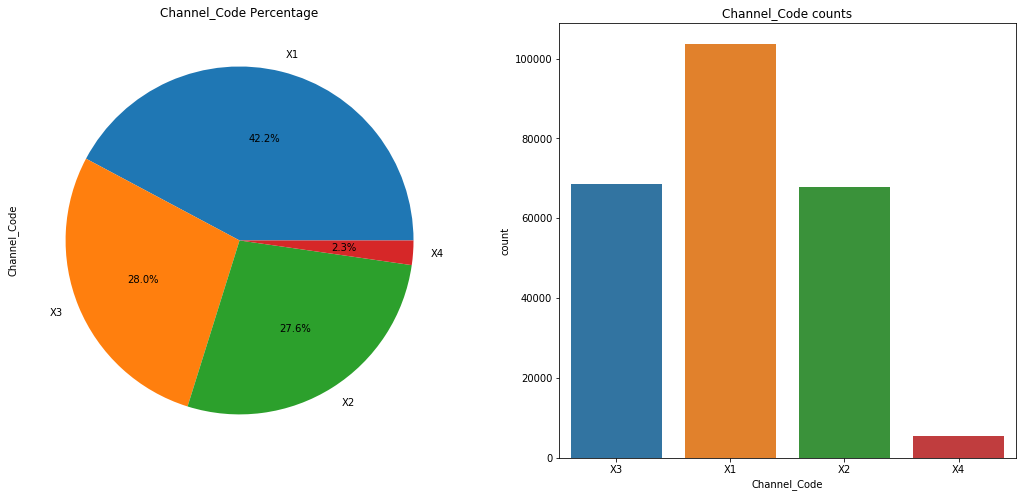

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,8))
train['Channel_Code'].value_counts().plot.pie(explode=None,ax=ax1,autopct='%1.1f%%')
ax1.set_title('Channel_Code Percentage')
sns.countplot(x='Channel_Code', data=train, ax=ax2)
ax2.set_title('Channel_Code counts')
plt.show()

* Most number of customers are Acquisition of X1 channel code followed by X2 and X3.

### Vintage

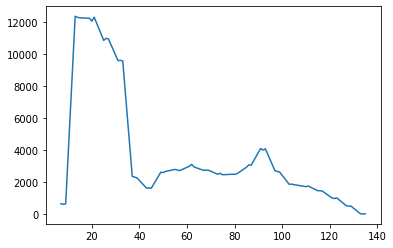

In [62]:
train['Vintage'].value_counts().sort_index().plot.line()

* most of the customers are vintage of 15 to 35 months.

### Credit_Product

In [63]:
train.Credit_Product.value_counts()

No     173682
Yes     72043
Name: Credit_Product, dtype: int64

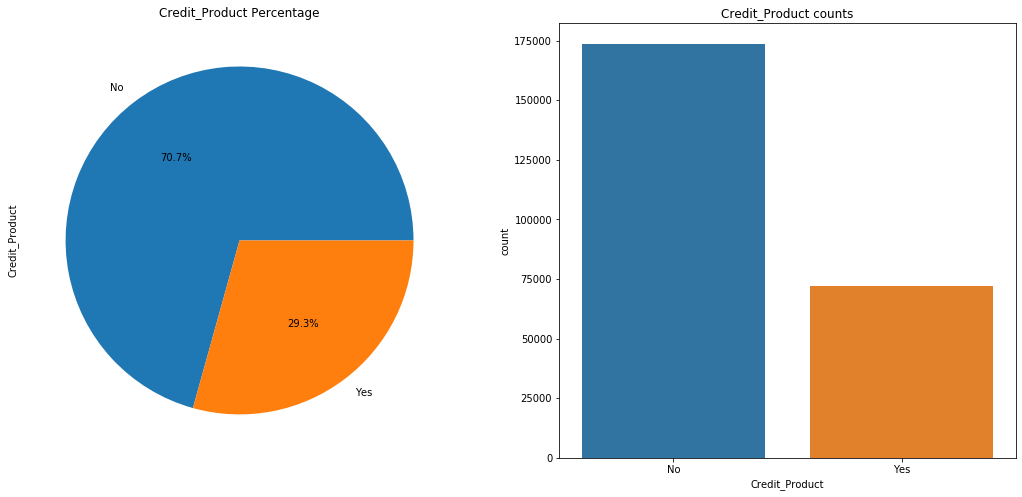

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,8))
train['Credit_Product'].value_counts().plot.pie(explode=None,ax=ax1,autopct='%1.1f%%')
ax1.set_title('Credit_Product Percentage')
sns.countplot(x='Credit_Product', data=train, ax=ax2)
ax2.set_title('Credit_Product counts')
plt.show()

* 70.7% customers do not have any credit card or any kind of home loan or personal lone.

### Avg_Account_Balance

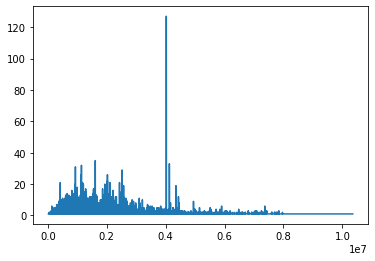

In [65]:
train['Avg_Account_Balance'].value_counts().sort_index().plot.line()

### Is_Active

In [67]:
train.Is_Active.value_counts()

No     150290
Yes     95435
Name: Is_Active, dtype: int64

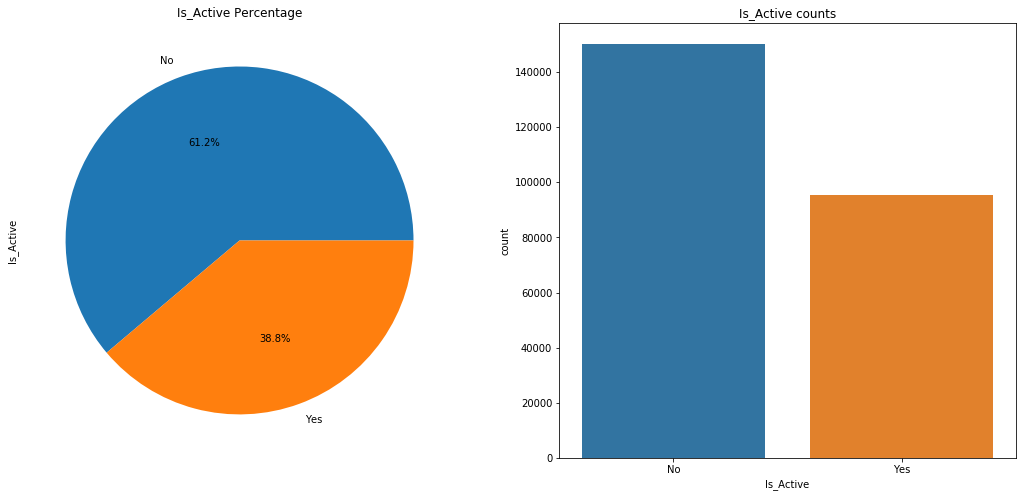

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,8))
train['Is_Active'].value_counts().plot.pie(explode=None,ax=ax1,autopct='%1.1f%%')
ax1.set_title('Is_Active Percentage')
sns.countplot(x='Is_Active', data=train, ax=ax2)
ax2.set_title('Is_Active counts')
plt.show()

* 61.2%(150290) customer's account is not active from the last 3 months.
* 38.8%(95435) customer's account is active from the last 3 months.

### Is_Lead

In [69]:
train.Is_Lead.value_counts()

0    187437
1     58288
Name: Is_Lead, dtype: int64

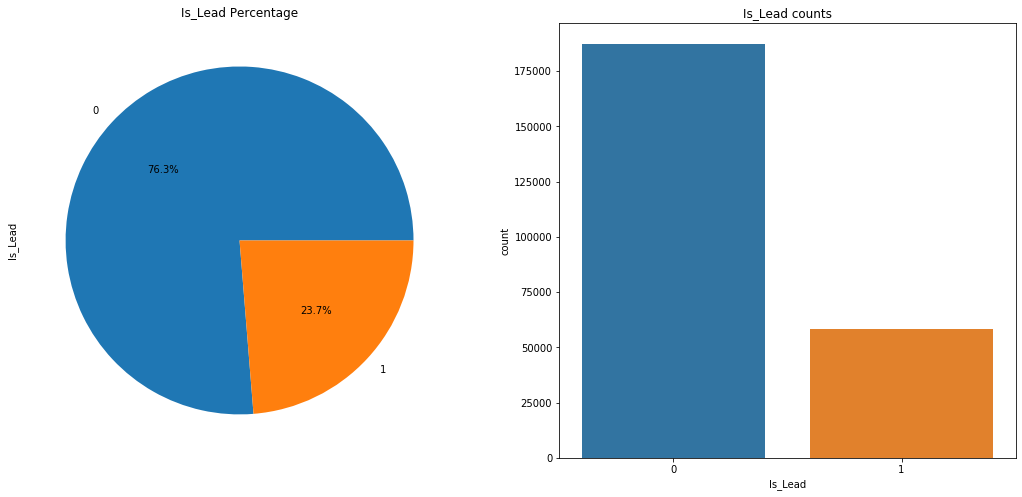

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,8))
train['Is_Lead'].value_counts().plot.pie(explode=None,ax=ax1,autopct='%1.1f%%')
ax1.set_title('Is_Lead Percentage')
sns.countplot(x='Is_Lead', data=train, ax=ax2)
ax2.set_title('Is_Lead counts')
plt.show()

* From the above data we can get that, only 23.7% customers are interested for credit card. Rest are not interested. And this is our target feature.

## Bi-Variate Analysis

In [72]:
train.head(0)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead


## Gender Vs Age

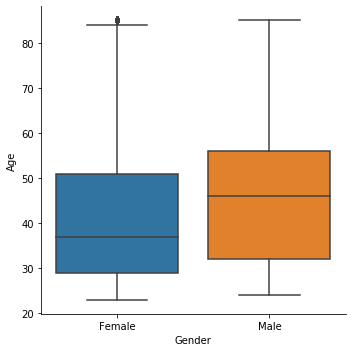

In [73]:
sns.catplot(x="Gender", y="Age",kind='box', data=train)

* Most of the male customer's age is around 48.
* Most of the female customer's age is around 37.

## Gender vs regional Code

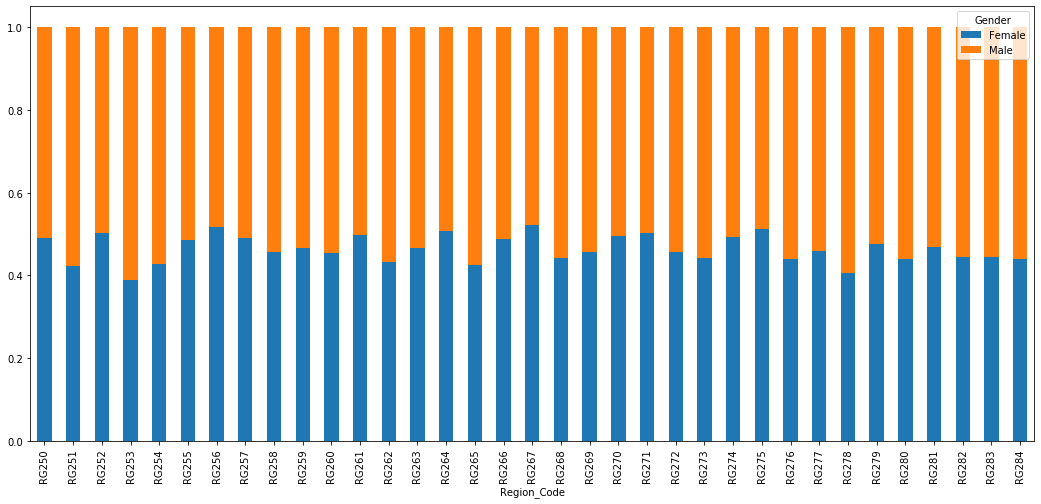

In [76]:
#plt.figure(figsize=(18,8))
props = train.groupby("Region_Code")['Gender'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked='True', figsize=(18,8))

* The above graph shows that how many percentage of males and females customers are there in each reginoal code.
* e.g. in region RG250 50% customers are male and 50% customers are female.

## Gender vs Occupation

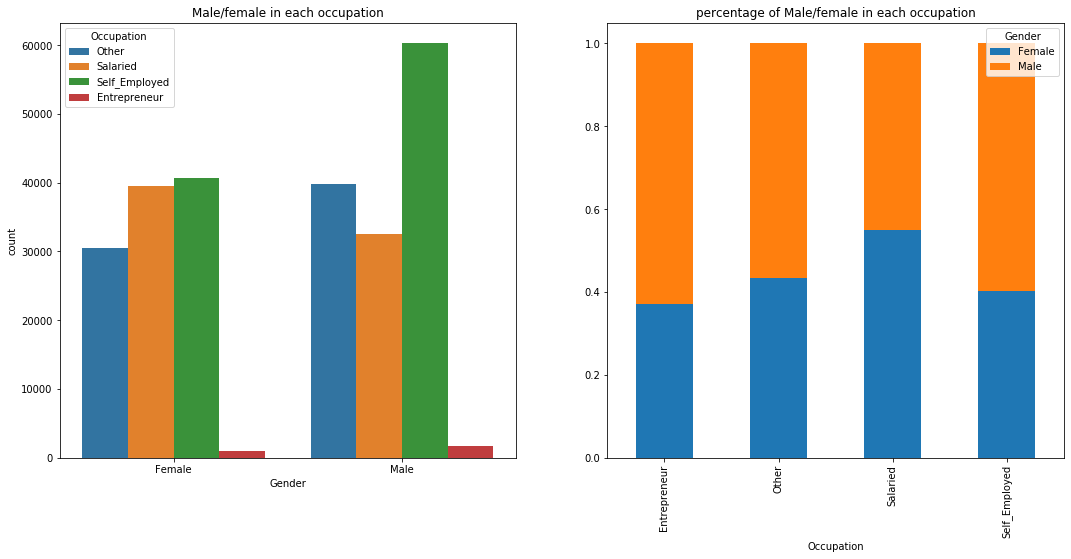

In [78]:
ig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,8))
sns.countplot(x="Gender",hue='Occupation',ax=ax1, data=train)
ax1.set_title("Male/female in each occupation")
props = train.groupby("Occupation")['Gender'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked='True', ax=ax2)
ax2.set_title("percentage of Male/female in each occupation")
plt.show()

* This shows that how many males and females are there in each occupation. 
* e.g. in self employed around 40%(approx 41000) customers are female and rest are male.

## Gender vs Channel Code

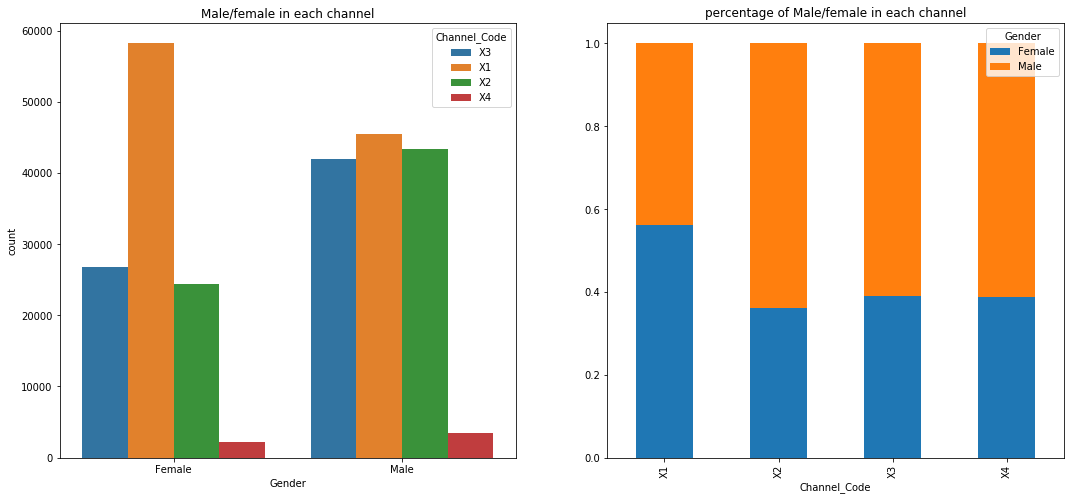

In [81]:
ig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,8))
sns.countplot(x="Gender",hue='Channel_Code',ax=ax1, data=train)
ax1.set_title("Male/female in each channel")
props = train.groupby("Channel_Code")['Gender'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked='True', ax=ax2)
ax2.set_title("percentage of Male/female in each channel")
plt.show()

* This shows that how many males and females are there in each channel.
* e.g. in channel X3 around 40%(approx 28000) customers are female and rest are male.

## Gender vs Vintage

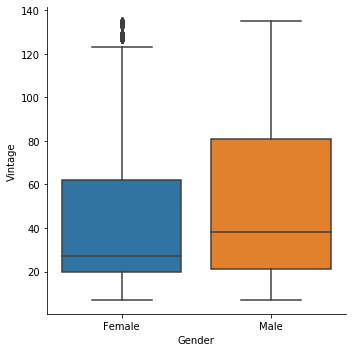

In [83]:
sns.catplot(x="Gender", y="Vintage",kind='box', data=train)

* Avg males are in vintage of 40 months.
* Avg females are in vintage of approx.25 months. But there are some outliers.

## Gender vs Credit Product

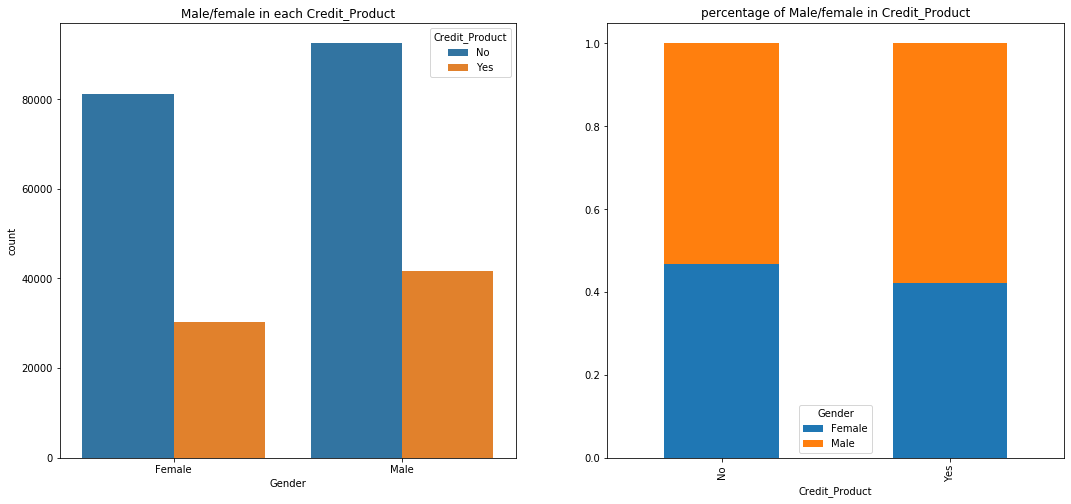

In [84]:
ig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,8))
sns.countplot(x="Gender",hue='Credit_Product',ax=ax1, data=train)
ax1.set_title("Male/female in each Credit_Product")
props = train.groupby("Credit_Product")['Gender'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked='True', ax=ax2)
ax2.set_title("percentage of Male/female in Credit_Product")
plt.show()

* Around 45% of male are having credit card or any kind of loan.

## Gender vs Avg account balance

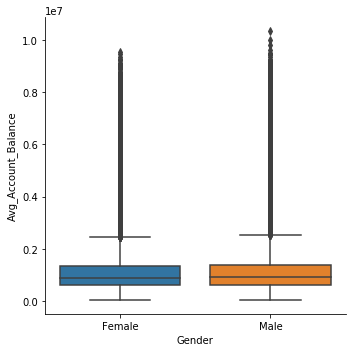

In [85]:
sns.catplot(x="Gender", y="Avg_Account_Balance",kind='box', data=train)

## Gender vs Is_active

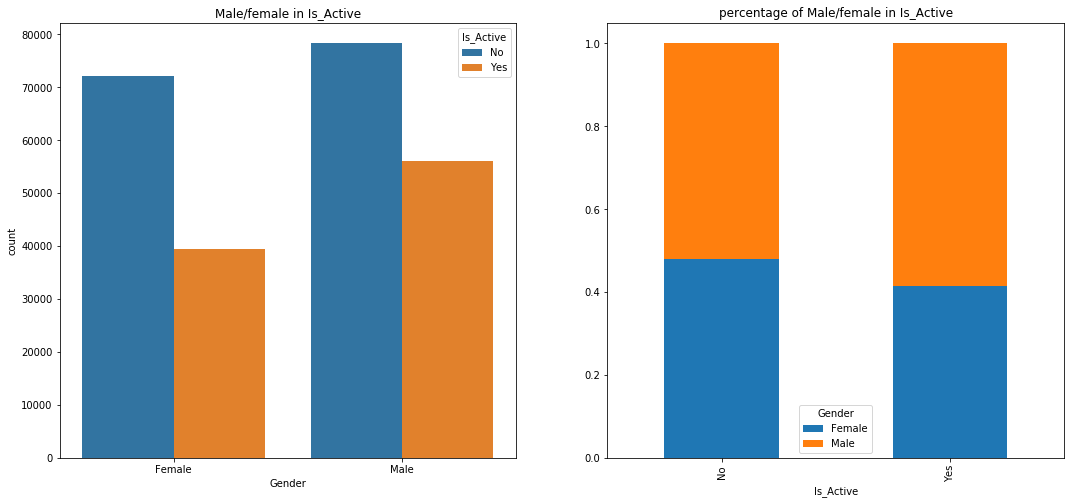

In [87]:
ig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,8))
sns.countplot(x="Gender",hue='Is_Active',ax=ax1, data=train)
ax1.set_title("Male/female in Is_Active")
props = train.groupby("Is_Active")['Gender'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked='True', ax=ax2)
ax2.set_title("percentage of Male/female in Is_Active")
plt.show()

* 55k male customer's account are active from last 3 months.
* 40k female customer's account are active from last 3 months.

## Gender vs Is_lead

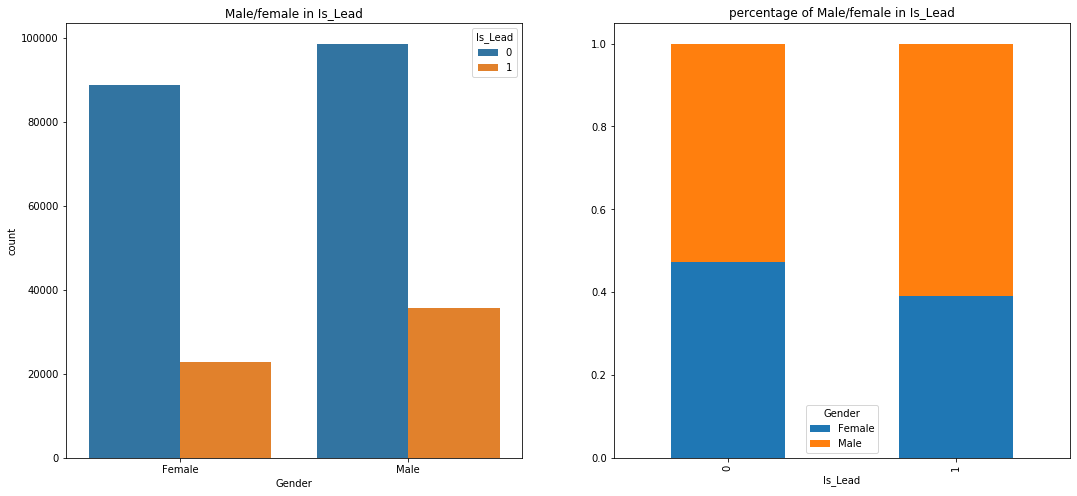

In [89]:
ig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,8))
sns.countplot(x="Gender",hue='Is_Lead',ax=ax1, data=train)
ax1.set_title("Male/female in Is_Lead")
props = train.groupby("Is_Lead")['Gender'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked='True', ax=ax2)
ax2.set_title("percentage of Male/female in Is_Lead")
plt.show()

* Around 20k female customers are interested for a new credit card.
* Around 35k make customers are interested for a new credit card.

## Regional_code vs Is_lead

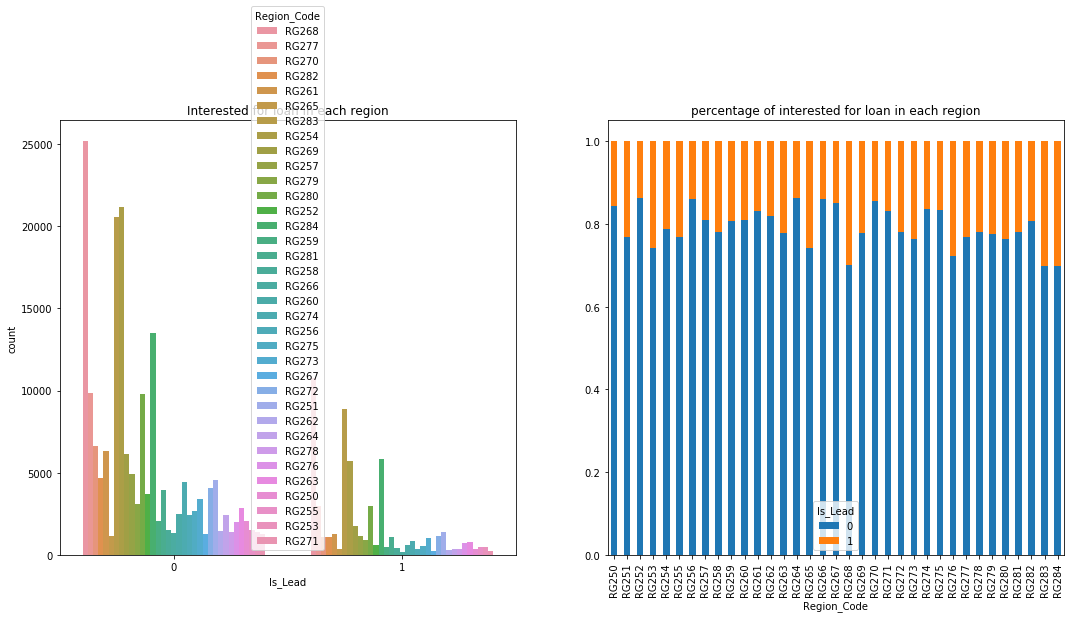

In [97]:
ig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,8))
sns.countplot(x="Is_Lead",hue='Region_Code',ax=ax1, data=train)
ax1.set_title("Interested for loan in each region")
props = train.groupby("Region_Code")['Is_Lead'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked='True', ax=ax2)
ax2.set_title("percentage of interested for loan in each region")
plt.show()

* From the above graph, We can concluide one thing, i.e. less no of people are interested for the credit card

## Occupation vs Is_Lead

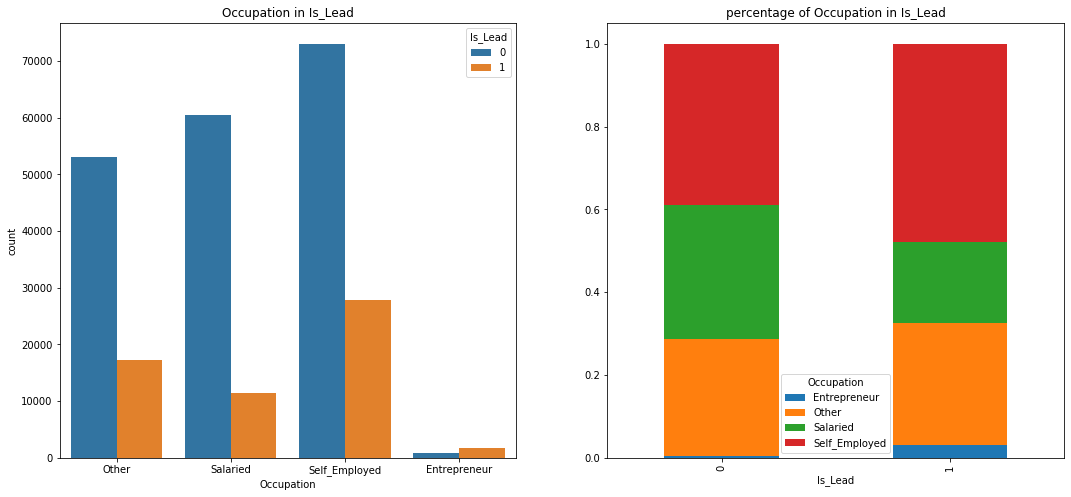

In [100]:
ig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,8))
sns.countplot(x="Occupation",hue='Is_Lead',ax=ax1, data=train)
ax1.set_title("Occupation in Is_Lead")
props = train.groupby("Is_Lead")['Occupation'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked='True', ax=ax2)
ax2.set_title("percentage of Occupation in Is_Lead")
plt.show()

* Mostly self employees are interested for the credit card.

## Channel_code vs Is_lead

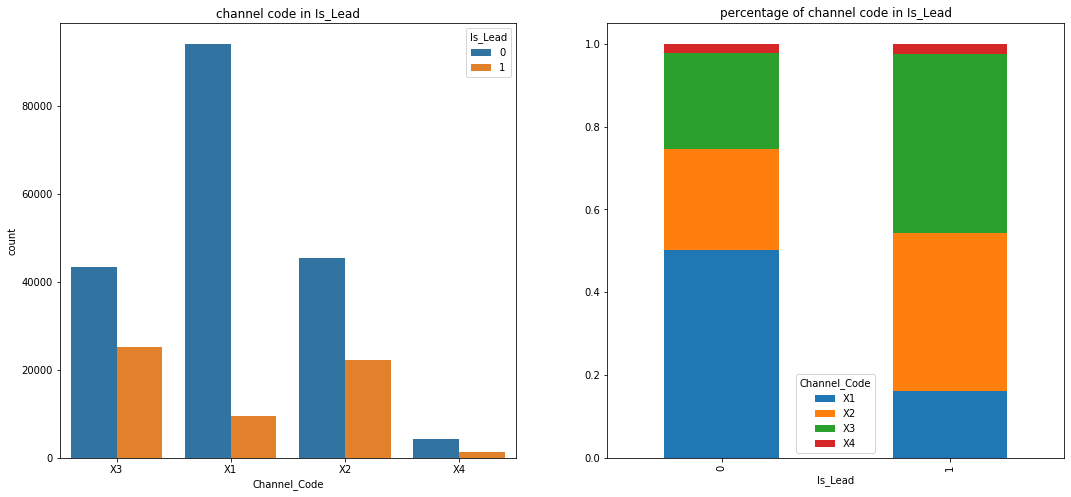

In [102]:
ig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,8))
sns.countplot(x="Channel_Code",hue='Is_Lead',ax=ax1, data=train)
ax1.set_title("channel code in Is_Lead")
props = train.groupby("Is_Lead")['Channel_Code'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked='True', ax=ax2)
ax2.set_title("percentage of channel code in Is_Lead")
plt.show()

* X3 and X2 channel customers are more interested for the credit card. So we need to approach to them more. 
* and we need to make a better plan for the credit card considering to the customer for X1 and X4 channel.

## Vintage vs Is_Lead

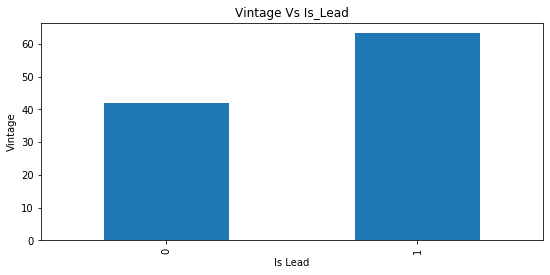

In [105]:
plt.figure(figsize=(9,4))
train.groupby('Is_Lead').Vintage.mean().plot(kind='bar')
plt.title('Vintage Vs Is_Lead')
plt.xlabel('Is Lead')
plt.ylabel('Vintage')
plt.show()

* The average vintage of the customers those are interested for the credit card is approximately 65 months. So we need to approach to those customers, whose account is there from the last 5 years.

## credit_product Vs Is_lead

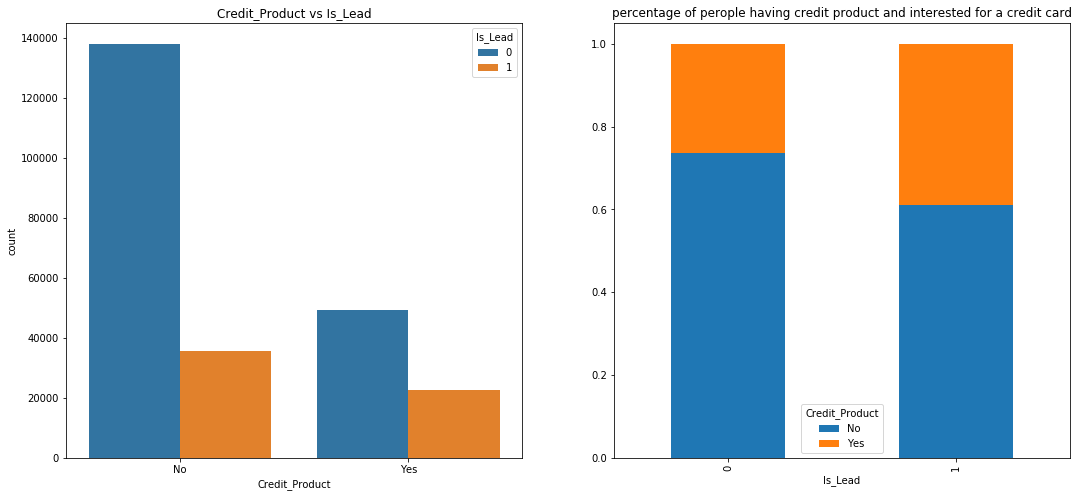

In [107]:
ig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,8))
sns.countplot(x="Credit_Product",hue='Is_Lead',ax=ax1, data=train)
ax1.set_title("Credit_Product vs Is_Lead")
props = train.groupby("Is_Lead")['Credit_Product'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked='True', ax=ax2)
ax2.set_title("percentage of perople having credit product and interested for a credit card")
plt.show()

* Around 30% of customer those are not having any kind of loan or credit card, are interested for a new credit card.
* Around 50% of customers those are having any kind of loan or credit card, are interested for a new credit card.

## Avg_account_balance vs is_lead

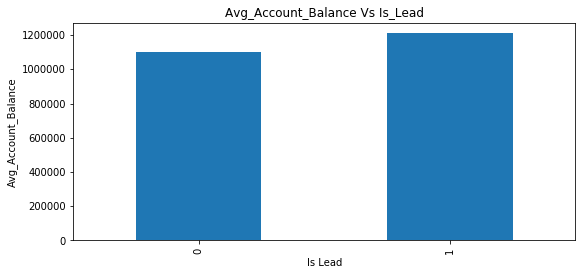

In [109]:
plt.figure(figsize=(9,4))
train.groupby('Is_Lead').Avg_Account_Balance.mean().plot(kind='bar')
plt.title('Avg_Account_Balance Vs Is_Lead')
plt.xlabel('Is Lead')
plt.ylabel('Avg_Account_Balance')
plt.show()

* We are not getting a better idea from this graph. We can see that around 1200000 account balance people are interested for a credit card and same account balance customers are also not interested.

## Is_Active vs Is_lead

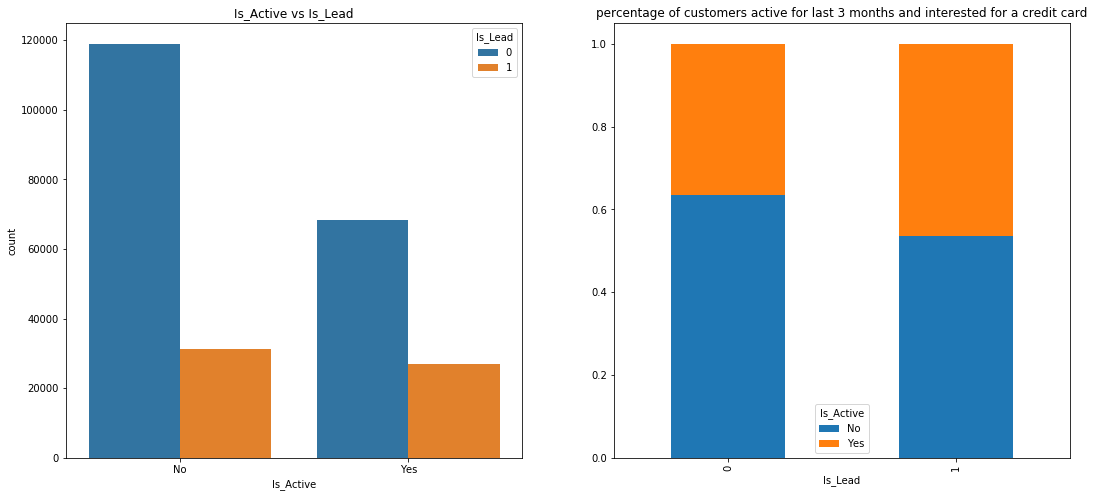

In [111]:
ig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,8))
sns.countplot(x="Is_Active",hue='Is_Lead',ax=ax1, data=train)
ax1.set_title("Is_Active vs Is_Lead")
props = train.groupby("Is_Lead")['Is_Active'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked='True', ax=ax2)
ax2.set_title("percentage of customers active for last 3 months and interested for a credit card")
plt.show()

In [113]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       245725 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  object
dtypes: int64(3), object(8)
memory usage: 20.6+ MB


# Handling Outliers

## Training Data

## Age

In [150]:
# this function will plot a subplot of boxplot,  distribution plot and joint plot between perticular feature and is_lead
def num_plots(feature,xlable):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.boxplot(feature)
    plt.xlabel(xlable)
    plt.subplot(122)
    sns.kdeplot(feature,shade=True)
    plt.figure(figsize=(10,5))
    sns.jointplot(feature,train.Is_Lead)

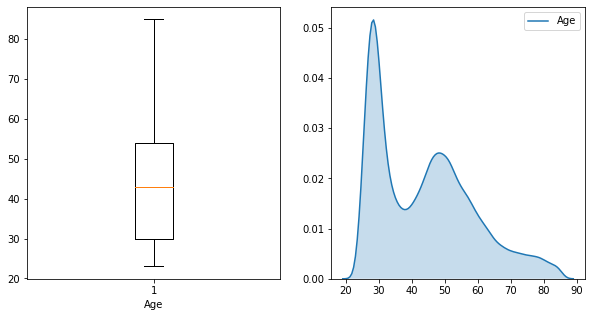

<Figure size 720x360 with 0 Axes>

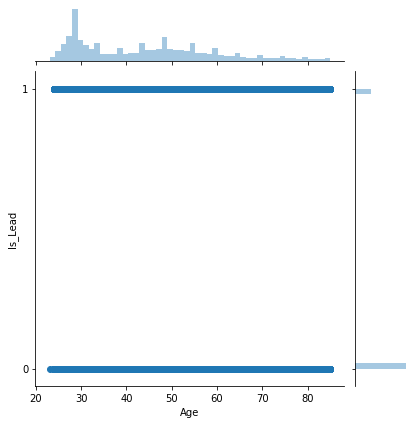

In [151]:
num_plots(train.Age,'Age')

* In Age, there are no outliers.

## Vintage 

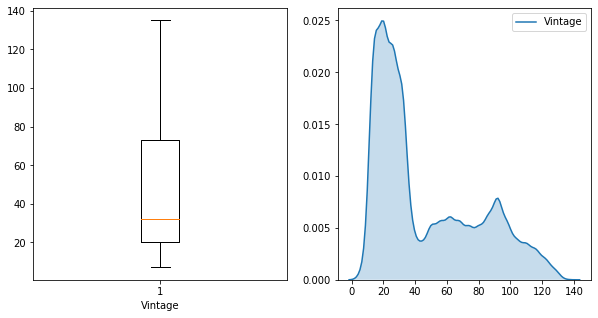

<Figure size 720x360 with 0 Axes>

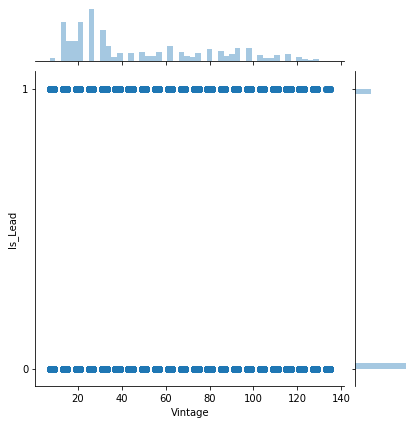

In [152]:
num_plots(train.Vintage,'Vintage')

* In vintage also there are no outliers.

## Avg account Balance

Inter Quantile Range (IQR):  762356.0


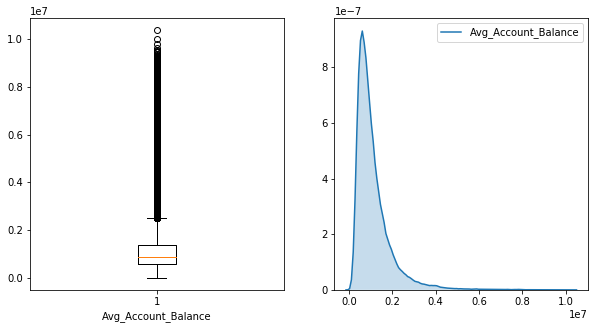

<Figure size 720x360 with 0 Axes>

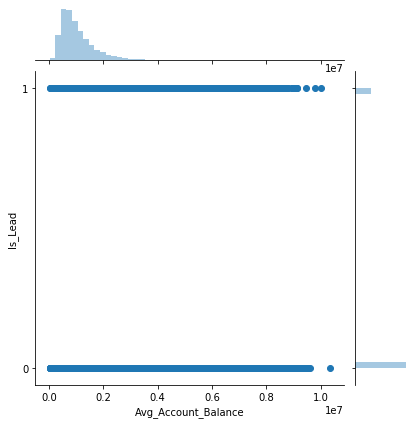

In [153]:
num_plots(train.Avg_Account_Balance,'Avg_Account_Balance')# have some outliers

Q1 = train.Avg_Account_Balance.quantile(0.25) # first quantile 
Q3 = train.Avg_Account_Balance.quantile(0.75) # second quantile
IQR = Q3 - Q1 # inter quantile range (IQR)
print('Inter Quantile Range (IQR): ',IQR)
# values above 1.5*IQR to the Q3 are considered as outliers 

train.Avg_Account_Balance[(train.Avg_Account_Balance > (Q3 + 1.5 * IQR))] = train.Avg_Account_Balance.quantile(0.95)

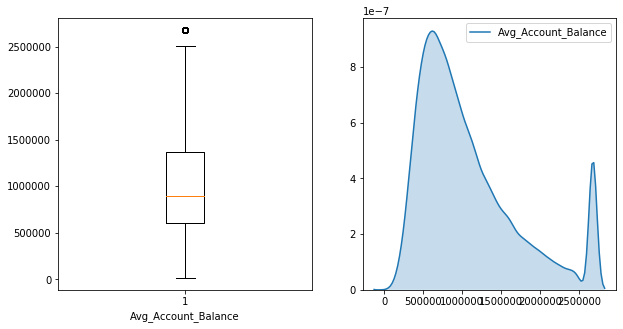

<Figure size 720x360 with 0 Axes>

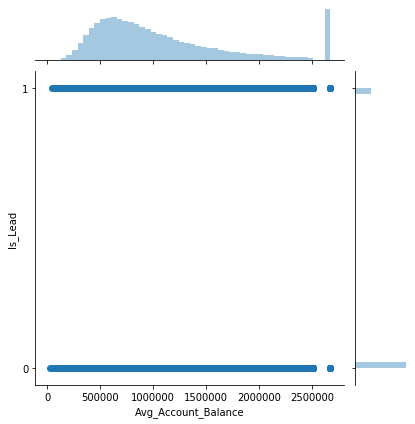

In [154]:
num_plots(train.Avg_Account_Balance,'Avg_Account_Balance')

## Test data
## Age

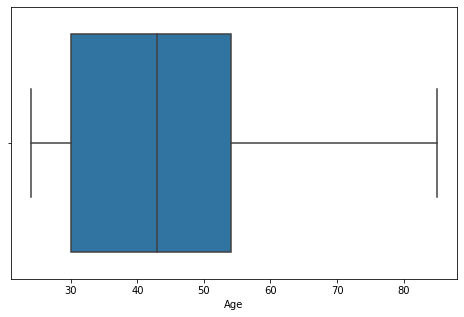

In [155]:
plt.figure(figsize=(8,5))
sns.boxplot('Age',data=test)

* There is no outliers in the Age.

## Vintage

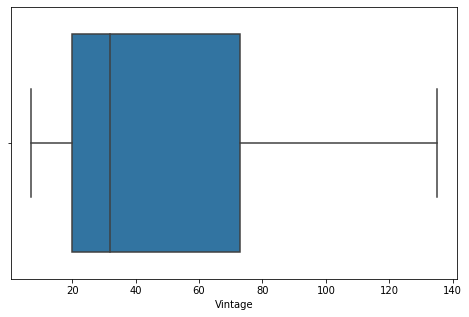

In [156]:
plt.figure(figsize=(8,5))
sns.boxplot('Vintage',data=test)

* There is no outlier in vintage as well.

## Avg account balance

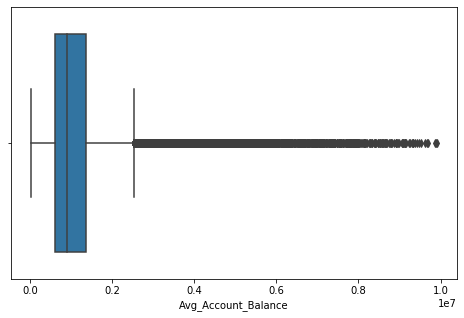

In [157]:
plt.figure(figsize=(8,5))
sns.boxplot('Avg_Account_Balance',data=test)

In [158]:
Q1 = test.Avg_Account_Balance.quantile(0.25) # first quantile 
Q3 = test.Avg_Account_Balance.quantile(0.75) # second quantile
IQR = Q3 - Q1 # inter quantile range (IQR)
print('Inter Quantile Range (IQR): ',IQR)
# values above 1.5*IQR to the Q3 are considered as outliers 

test.Avg_Account_Balance[(test.Avg_Account_Balance > (Q3 + 1.5 * IQR))] = test.Avg_Account_Balance.quantile(0.95)

Inter Quantile Range (IQR):  767616.0


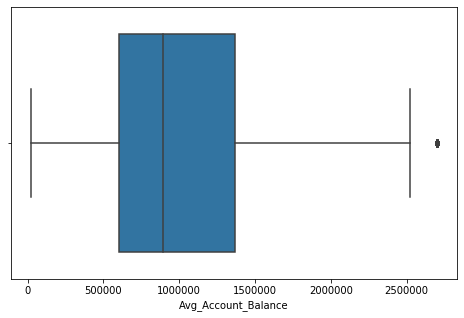

In [159]:
plt.figure(figsize=(8,5))
sns.boxplot('Avg_Account_Balance',data=test)

In [160]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [161]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366.0,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,No,925537.0,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949.0,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070.0,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087.0,No


# Building Model

In [162]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       245725 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  object
dtypes: int64(3), object(8)
memory usage: 20.6+ MB


In [163]:
train = train.drop(['ID'], axis=1)
test = test.drop(['ID'], axis =1)
train.head(1)

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,RG268,Other,X3,43,No,1045696,No,0


In [181]:
train = pd.get_dummies(train,drop_first=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   Age                       245725 non-null  int64
 1   Vintage                   245725 non-null  int64
 2   Avg_Account_Balance       245725 non-null  int64
 3   Gender_Male               245725 non-null  uint8
 4   Region_Code_RG251         245725 non-null  uint8
 5   Region_Code_RG252         245725 non-null  uint8
 6   Region_Code_RG253         245725 non-null  uint8
 7   Region_Code_RG254         245725 non-null  uint8
 8   Region_Code_RG255         245725 non-null  uint8
 9   Region_Code_RG256         245725 non-null  uint8
 10  Region_Code_RG257         245725 non-null  uint8
 11  Region_Code_RG258         245725 non-null  uint8
 12  Region_Code_RG259         245725 non-null  uint8
 13  Region_Code_RG260         245725 non-null  uint8
 14  Region_Code_RG261   

In [182]:
X = train.drop(columns=['Is_Lead_1'], axis=1)
y= train.Is_Lead_1

In [165]:
test = pd.get_dummies(test,drop_first=True)

## Train Test Split

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [184]:
X_train.head()

,Age,Vintage,Avg_Account_Balance,Gender_Male,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,Region_Code_RG254,Region_Code_RG255,Region_Code_RG256,...,Region_Code_RG283,Region_Code_RG284,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_Yes,Is_Active_Yes
37052,27,32,2673533,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
30570,66,87,1101588,1,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,1
189426,28,21,1581983,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
139164,84,38,1056501,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
106300,43,45,1651056,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0


In [185]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [186]:
print('Train size:{}'.format(X_train.shape))
print('Test size:{}'.format(X_test.shape))

Train size:(184293, 46)
Test size:(61432, 46)


In [190]:
model_LR = LogisticRegression()
model_LR.fit(X_train,y_train)
y_preds = model_LR.predict(X_test)


print('Accuracy: {:2.2f}%'.format(accuracy_score(y_test, y_preds) * 100))
print('Precision score: {:2.2f}%'.format(precision_score(y_test, y_preds)*100))
print('Recall score: {:2.2f}%'.format(recall_score(y_test, y_preds)*100))
print('F1-score: {:2.2f}%'.format(f1_score(y_test, y_preds) * 100),'\n')
 
print('confusion matrix','\n \n',confusion_matrix(y_test, y_preds))
fpr,tpr,threshold=roc_curve(y_test,y_preds)
roc_auc = auc(fpr,tpr)
print('\n AUC',roc_auc)

Accuracy: 77.55%
Precision score: 64.39%
Recall score: 12.09%
F1-score: 20.36% 

confusion matrix 
 
 [[45878   975]
 [12816  1763]]

 AUC 0.5500587972779423


In [188]:

model = LogisticRegression()
model.fit(X_train,y_train)
y_pred_prob = model.predict_proba(X_test)

print(y_pred_prob[:,1])
y_preds=[1 if i>0.35 else 0 for i in y_pred_prob[:,1]]
np.array(y_preds)

print('Accuracy: {:2.2f}%'.format(accuracy_score(y_test, y_preds) * 100))
print('Precision score: {:2.2f}%'.format(precision_score(y_test, y_preds)*100))
print('Recall score: {:2.2f}%'.format(recall_score(y_test, y_preds)*100))
print('F1-score: {:2.2f}%'.format(f1_score(y_test, y_preds) * 100),'\n')
 
print('confusion matrix','\n \n',confusion_matrix(y_test, y_preds))
fpr,tpr,threshold=roc_curve(y_test,y_preds)
roc_auc = auc(fpr,tpr)
print('\n AUC',roc_auc)

[0.11812375 0.10925871 0.10920366 ... 0.04366388 0.1498079  0.09292891]
Accuracy: 73.36%
Precision score: 44.29%
Recall score: 47.50%
F1-score: 45.84% 

confusion matrix 
 
 [[38144  8709]
 [ 7654  6925]]

 AUC 0.6445595229408788


In [189]:
model = RandomForestClassifier(n_estimators=500,random_state = 0)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)

print('RF - Accuracy: {:2.2f}%'.format(accuracy_score(y_test, y_preds) * 100))
print('RF - Precision score: {:2.2f}%'.format(precision_score(y_test, y_preds)*100))
print('RF - Recall score: {:2.2f}%'.format(recall_score(y_test, y_preds)*100))
print('RF - F1-score: {:2.2f}%'.format(f1_score(y_test, y_preds) * 100),'\n')
 
print('confusion matrix','\n \n',confusion_matrix(y_test, y_preds))
fpr,tpr,threshold=roc_curve(y_test,y_preds)
roc_auc = auc(fpr,tpr)
print('\n AUC',roc_auc)

RF - Accuracy: 77.57%
RF - Precision score: 54.96%
RF - Recall score: 30.37%
RF - F1-score: 39.12% 

confusion matrix 
 
 [[43224  3629]
 [10151  4428]]

 AUC 0.6131347582008105


In [192]:
submission = pd.read_csv('sample_submission_eyYijxG.csv')
final_predictions = model_LR.predict(test)
submission['Is_Lead'] = final_predictions
#only positive predictions for the target variable
#submission['Is_Lead'] = submission['Is_Lead'].apply(lambda x: 0 if x<0 else x)
submission.to_csv('my_submission.csv', index=False)

In [193]:
logModel = LogisticRegression()

In [197]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

In [195]:
from sklearn.model_selection import GridSearchCV

In [198]:
clf = GridSearchCV(logModel, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

In [ ]:
best_clf = clf.fit(X_train, y_train)

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 24.5min
